# Generate Structures

Use a desired model to generate molecules and perform filtering to identify a shortlist of candidates for further refinement.

In [1]:
from settings import *

# Initialize Scorers

In [2]:
from predictors import get_led3, get_qsar, get_qsar_reg, get_sascore, run_predictors

# load predictors/scorers
led3_path = "models/sa_predictors/led3_chembl200k_random_hist_xgboost.model"
led3_scorer = get_led3(led3_path, False)
sascore_scorer = get_sascore(False)
qsar_scorer = get_qsar(False)
qsar_scorer_reg = get_qsar_reg()

2023-03-22 17:09:59.519 | INFO     | led3_score.fingerprints.fingerprints:__init__:18 - Fingerprint DrugEx Fingerprint (Binary Morgan Fingerprint with Radius 3 and 2048 bits using Features: False + Chemical Features) initialized.
2023-03-22 17:09:59.550 | INFO     | led3_score.fingerprints.fingerprints:__init__:18 - Fingerprint DrugEx Fingerprint (Binary Morgan Fingerprint with Radius 3 and 2048 bits using Features: False + Chemical Features) initialized.


In [3]:
# sanity check on known molecules from training data
test_mols = [
    "Cc1ccc(C)n1Cc1ccc(-c2nn(C(=O)N(C)C)nn2)cc1", # active
    "CCCCCCCCCC(=NO)c1c(O)ccc(-c2ccc(OC)cc2)c1" # inactive
]
predictors = [led3_scorer, qsar_scorer, qsar_scorer_reg, sascore_scorer]
run_predictors(test_mols, predictors=predictors)

  0%|          | 0/4 [00:00<?, ?it/s]

/home/martin/.conda/envs/led3-drugex/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,LED3Scorer,XGBClassifier,XGBRegressor,SA,SMILES
0,0.837656,0.944273,6.872365,2.596309,Cc1ccc(C)n1Cc1ccc(-c2nn(C(=O)N(C)C)nn2)cc1
1,0.107575,0.005677,4.439261,2.238184,CCCCCCCCCC(=NO)c1c(O)ccc(-c2ccc(OC)cc2)c1


In [4]:
predictor_keys = [x.getKey() for x in predictors]
predictor_keys

['LED3Scorer', 'XGBClassifier', 'XGBRegressor', 'SA']

## Generate Molecules

Generate a large set of compounds with the current model, score, filter and analyze them.

In [5]:
# get original smiles

smiles_original = TRAIN_DF.SMILES.to_list()
len(smiles_original)

700

In [63]:
# substitute with a path to the desired model
MODELES_RL_ROOT = f"models/RL/Q99685/drugex-led3-qsar-led3-chembl200k-v6/led3-qsar_cls_2023-03-21_16-55-17_932942"
MODELS_RL_PATH_NOW = f'{MODELES_RL_ROOT}/Q99685_RL'

In [19]:
# RL model
from drugex.training.models.transform import GraphModel
from drugex.data.corpus.vocabulary import VocGraph

MODEL_FILE_RL = f'{MODELS_RL_PATH_NOW}.pkg'

vocabulary = VocGraph.fromFile(f"{DATASETS_ENCODED_PATH}/{TARGET_ID}_train.tsv.vocab")
rl_model = GraphModel(voc_trg=vocabulary, use_gpus=GPUS_RL)
rl_model.loadStatesFromFile(MODEL_FILE_RL)

In [ ]:
import os

smiles_rl, frags = rl_model.sample_smiles(
    smiles_original, 
    num_samples=100_000,
    batch_size=1024
)

Standardizing molecules (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

Initialized empty dataset. The data set file does not exist (yet): /tmp/tmp736amspz. You can add data by calling this instance with the appropriate parameters.


Creating fragment-molecule pairs (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

Only one retrieved fragment for molecule: CN(C)C(=S)SC(=S)N1CCOCC1. Skipping...
Only one retrieved fragment for molecule: C1CCN(SSN2CCCCC2)CC1. Skipping...
Only one retrieved fragment for molecule: C1CN(SSN2CCOCC2)CCO1. Skipping...
Only one retrieved fragment for molecule: Cc1coc2c1C(=O)C(=O)c1c-2ccc2c1CCCC2(C)C. Skipping...
Only one retrieved fragment for molecule: S=C(SSC(=S)N1CCCc2ccccc21)N1CCCc2ccccc21. Skipping...
Only one retrieved fragment for molecule: S=C(SSC(=S)N1CCCC1)N1CCCC1. Skipping...
Only one retrieved fragment for molecule: S=C(SSC(=S)N1CCOCC1)N1CCOCC1. Skipping...
Only one retrieved fragment for molecule: S=C(SSC(=S)N1CCCCC1)N1CCCCC1. Skipping...
Only one retrieved fragment for molecule: S=C(SSC(=S)C1CCCCC1)C1CCCCC1. Skipping...
Only one retrieved fragment for molecule: CN(C)C(=S)SSC(=S)N(C)C. Skipping...
Only one retrieved fragment for molecule: S=C(c1ccc(Br)cc1)N1CCOCC1. Skipping...
Only one retrieved fragment for molecule: CN1CCN(C(=S)SSC(=S)N2CCN(C)CC2)CC1. Skippi

Encoding fragment-molecule pairs. (batch processing):   0%|          | 0/1 [00:00<?, ?it/s]

Generating molecules:   0%|          | 0/100000 [00:00<?, ?it/s]

In [60]:
df_smiles_rl_sample = pd.DataFrame({'SMILES': smiles_rl})
df_smiles_rl_sample.to_csv(f'{DATA_GENERATED_FOLDER}/{TARGET_ID}.tsv', index=False, sep="\t")
df_smiles_rl_sample

,SMILES
0,O=C(OC(C(F)(F)F)C(F)(F)F)N1CCC(c2ccc(CC3CCOCC3...
1,O=C(OC(C(F)(F)F)C(F)(F)F)N1CC(N2CCN(C(=O)c3ccc...
2,O=C(OC(C(F)(F)F)C(F)(F)F)N1CCC(c2cccc(Nc3ccc(F...
3,Cc1cc(F)ccc1OC1CCN(C(=O)C2CCN(c3ccc(C(F)(F)F)c...
4,CCCCCCc1cccc2c1C(CO)C=CC=C2
...,...
99995,COc1ccc(C(=O)C2CCN(C(=O)c3cccc(Cl)c3)CC2)cc1O
99996,N#Cc1ccc(COCCN2CCN(C(=O)n3cncn3)CC2)cc1
99997,COc1cccc(NC(=O)N2CC(CC(=O)c3cccc(-c4ccccc4F)c3...
99998,N#Cc1cccc(OC(=O)N2CCN(Cc3ccccc3O)CC2)c1


In [61]:
df_smiles_rl_sample_scores = run_predictors(df_smiles_rl_sample.SMILES, predictors=predictors)
df_smiles_rl_sample_scores.to_csv(f'{DATA_GENERATED_FOLDER}/{TARGET_ID}.tsv', index=False, sep="\t")
df_smiles_rl_sample_scores

  0%|          | 0/4 [00:00<?, ?it/s]

/home/martin/.conda/envs/led3-drugex/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



,LED3Scorer,XGBClassifier,XGBRegressor,SA,SMILES
0,0.644972,0.894494,7.399830,2.861300,O=C(OC(C(F)(F)F)C(F)(F)F)N1CCC(c2ccc(CC3CCOCC3...
1,0.189797,0.833057,7.630073,2.876022,O=C(OC(C(F)(F)F)C(F)(F)F)N1CC(N2CCN(C(=O)c3ccc...
2,0.765572,0.932683,7.705853,2.553352,O=C(OC(C(F)(F)F)C(F)(F)F)N1CCC(c2cccc(Nc3ccc(F...
3,0.964065,0.543750,6.896514,2.315613,Cc1cc(F)ccc1OC1CCN(C(=O)C2CCN(c3ccc(C(F)(F)F)c...
4,0.155427,0.022102,5.475140,3.189610,CCCCCCc1cccc2c1C(CO)C=CC=C2
...,...,...,...,...,...
99995,0.994086,0.027784,6.268208,1.988630,COc1ccc(C(=O)C2CCN(C(=O)c3cccc(Cl)c3)CC2)cc1O
99996,0.984901,0.581005,7.149306,2.497281,N#Cc1ccc(COCCN2CCN(C(=O)n3cncn3)CC2)cc1
99997,0.637425,0.151714,6.111521,2.135126,COc1cccc(NC(=O)N2CC(CC(=O)c3cccc(-c4ccccc4F)c3...
99998,0.999267,0.653435,6.470309,2.106553,N#Cc1cccc(OC(=O)N2CCN(Cc3ccccc3O)CC2)c1


### Analyze and Filter

In [64]:
# load the saved generated data set with all scores

df_smiles_rl_sample_scores = pd.read_table(f'{DATA_GENERATED_FOLDER}/{TARGET_ID}.tsv', sep="\t")
df_smiles_rl_sample_scores

,LED3Scorer,XGBClassifier,XGBRegressor,SA,SMILES
0,0.644972,0.894494,7.399830,2.861300,O=C(OC(C(F)(F)F)C(F)(F)F)N1CCC(c2ccc(CC3CCOCC3...
1,0.189797,0.833057,7.630073,2.876022,O=C(OC(C(F)(F)F)C(F)(F)F)N1CC(N2CCN(C(=O)c3ccc...
2,0.765572,0.932683,7.705853,2.553352,O=C(OC(C(F)(F)F)C(F)(F)F)N1CCC(c2cccc(Nc3ccc(F...
3,0.964065,0.543750,6.896514,2.315613,Cc1cc(F)ccc1OC1CCN(C(=O)C2CCN(c3ccc(C(F)(F)F)c...
4,0.155427,0.022102,5.475140,3.189610,CCCCCCc1cccc2c1C(CO)C=CC=C2
...,...,...,...,...,...
99995,0.994086,0.027784,6.268208,1.988630,COc1ccc(C(=O)C2CCN(C(=O)c3cccc(Cl)c3)CC2)cc1O
99996,0.984901,0.581005,7.149306,2.497281,N#Cc1ccc(COCCN2CCN(C(=O)n3cncn3)CC2)cc1
99997,0.637425,0.151714,6.111521,2.135126,COc1cccc(NC(=O)N2CC(CC(=O)c3cccc(-c4ccccc4F)c3...
99998,0.999267,0.653435,6.470309,2.106553,N#Cc1cccc(OC(=O)N2CCN(Cc3ccccc3O)CC2)c1


array([[<AxesSubplot: title={'center': 'LED3Scorer'}>,
        <AxesSubplot: title={'center': 'XGBClassifier'}>],
       [<AxesSubplot: title={'center': 'XGBRegressor'}>,
        <AxesSubplot: title={'center': 'SA'}>]], dtype=object)

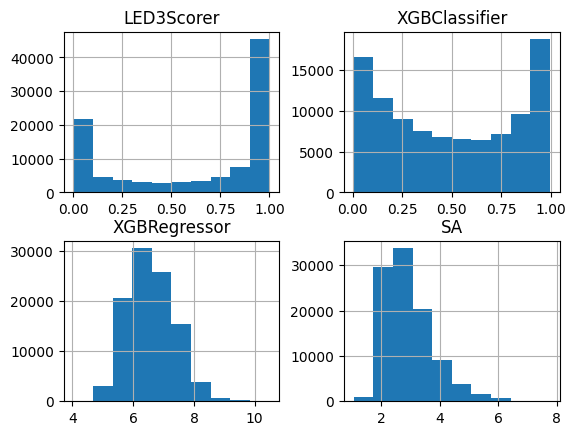

In [65]:
df_smiles_rl_sample_scores[predictor_keys].hist()

In [66]:
df_smiles_original_scores = run_predictors(smiles_original, predictors=predictors)
df_smiles_original_scores

  0%|          | 0/4 [00:00<?, ?it/s]

/home/martin/.conda/envs/led3-drugex/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



,LED3Scorer,XGBClassifier,XGBRegressor,SA,SMILES
0,0.964768,0.017040,4.830327,2.268719,O=C(Cc1ccc(Cc2ccccc2)cc1)OCC1CO1
1,0.107575,0.005677,4.439261,2.238184,CCCCCCCCCC(=NO)c1c(O)ccc(-c2ccc(OC)cc2)c1
2,0.957080,0.006967,5.324044,2.448781,O=C1C=CC(=O)N1c1ccccc1I
3,0.974888,0.007051,5.770197,1.973987,O=C1C=CC(=O)N1c1ccccc1-c1ccccc1
4,0.958588,0.907512,6.735845,2.899974,O=C1CCC(COC(=O)N2CCC(COc3c(Cl)cc(F)cc3)CC2)N1
...,...,...,...,...,...
695,0.994868,0.024584,5.911016,2.084597,O=C(c1ccc(Cl)cc1)C1CCN(C(=O)c2cc(O)cc(Br)c2)CC1
696,0.978401,0.965686,7.747365,2.335487,O=C(c1ccc(Sc2ccccc2)cc1)C1CCN(C(=O)c2cc(O)c(F)...
697,0.914030,0.061915,6.464849,2.305186,O=C(N1CCCCC1)n1nnc(Cc2ccc(-c3ccccc3)cc2)n1
698,0.837656,0.944273,6.872365,2.596309,Cc1ccc(C)n1Cc1ccc(-c2nn(C(=O)N(C)C)nn2)cc1


array([[<AxesSubplot: title={'center': 'LED3Scorer'}>,
        <AxesSubplot: title={'center': 'XGBClassifier'}>],
       [<AxesSubplot: title={'center': 'XGBRegressor'}>,
        <AxesSubplot: title={'center': 'SA'}>]], dtype=object)

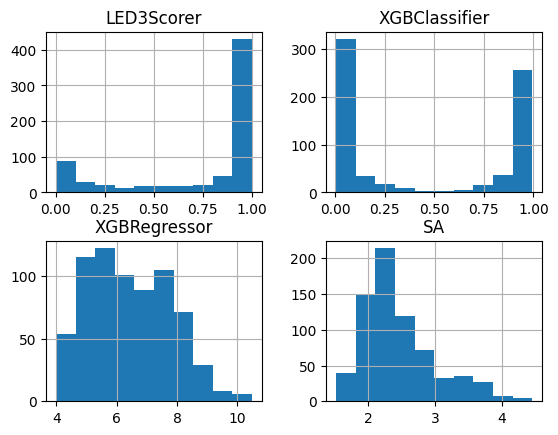

In [67]:
df_smiles_original_scores[predictor_keys].hist()

In [68]:
# make a shortlist of molecules
shortlist = df_smiles_rl_sample_scores[(df_smiles_rl_sample_scores.LED3Scorer > 0.8) & (df_smiles_rl_sample_scores.XGBClassifier > 0.8)].copy()
shortlist.to_csv(f'{DATA_GENERATED_FOLDER}/{TARGET_ID}_shortlist.tsv', index=False, sep="\t")
shortlist

,LED3Scorer,XGBClassifier,XGBRegressor,SA,SMILES
6,0.994850,0.838922,7.891945,3.227542,O=C(N1CCN(OC(c2ccccc2)c2cccnc2)CC1)n1cncn1
7,0.977528,0.982657,8.173609,2.352805,O=C(c1ccc(Sc2cccc(C(F)(F)F)c2)cc1)C1CCN(C(=O)c...
8,0.946449,0.843146,6.570932,3.082074,O=C(OCC(F)(F)F)N1CCCC(OCc2ccc(Cl)cc2Cc2ccc3c(c...
10,0.980875,0.906666,7.633739,2.569385,O=C(Nc1ccc2c(c1)OCO2)C1CCN(C(=O)OC(C(F)(F)F)C(...
13,0.995883,0.869943,7.441023,2.278755,O=C(c1cccc(-c2ccc(C(F)(F)F)cc2)c1)C1CCN(C(=O)c...
...,...,...,...,...,...
99871,0.997041,0.822556,6.844550,2.370118,O=Cc1ccc(N2CCC(C(=O)c3ccc(Sc4ccc(F)cc4)cc3)CC2...
99897,0.995911,0.968961,7.479565,2.445486,O=C(N1CCN(c2ccc(Br)c([N+](=O)[O-])c2)CC1)n1nnc...
99951,0.966054,0.967692,8.113548,2.594992,O=C(c1ccc(Sc2ccc(SC(F)(F)F)cc2)cc1)C1CCN(C(=O)...
99970,0.974232,0.958466,7.585723,2.476570,O=C(N1CCN(Cc2ccc(Cl)c(F)c2)CC1)n1nnc2cccnc21


In [69]:
from utils import smilesToGrid

smilesToGrid(shortlist.SMILES.sample(100))

MolGridWidget()

In [70]:
# load up the data frame with all obtained sets before RL
df_all = pd.read_table(GENERATED_FT_PATH_ALL, sep='\t', header=0)
df_all

,SMILES,Set,Descriptor_MorganFP_0,Descriptor_MorganFP_1,Descriptor_MorganFP_2,Descriptor_MorganFP_3,Descriptor_MorganFP_4,Descriptor_MorganFP_5,Descriptor_MorganFP_6,Descriptor_MorganFP_7,...,Descriptor_MorganFP_2043,Descriptor_MorganFP_2044,Descriptor_MorganFP_2045,Descriptor_MorganFP_2046,Descriptor_MorganFP_2047,TSNE_1,TSNE_2,LED3Scorer,XGBClassifier,XGBRegressor
0,OC1(C(F)(F)F)c2cc(Cc3ccc4c(c3)OCO4)ccc2Oc2c3cc...,Train_FT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.240914,5.272819,0.017553,0.640557,6.947854
1,O=C(c1cccc(O)c1)N1CCC(c2ccc(-c3nn(-c4ccc(F)c(F...,Train_FT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.343200,-2.592057,0.883202,0.689384,6.911160
2,FC(F)(F)C(c1ccc2c(c1)OCCO2)C(F)(F)F,Train_FT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-4.205234,-1.413849,0.956162,0.057099,5.909824
3,O=C(OC1CCN(C(=O)OC(C(F)(F)F)C(F)(F)F)CC1)N1CCC...,Train_FT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-5.101933,11.061301,0.060991,0.918052,7.759538
4,CC(C)c1ccc(C(=O)C2CCN(C(=O)c3ccc(F)c(O)c3)CC2)cc1,Train_FT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.000411,-5.893925,0.978682,0.914796,6.991051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11227,O=C(c1ccc(Cl)cc1)C1CCN(C(=O)c2cc(O)cc(Br)c2)CC1,Original,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.080431,-5.426588,0.998720,0.024584,5.911016
11228,O=C(c1ccc(Sc2ccccc2)cc1)C1CCN(C(=O)c2cc(O)c(F)...,Original,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.449707,-7.257044,0.994950,0.965686,7.747364
11229,O=C(N1CCCCC1)n1nnc(Cc2ccc(-c3ccccc3)cc2)n1,Original,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-14.647965,2.371297,0.786237,0.061915,6.464849
11230,Cc1ccc(C)n1Cc1ccc(-c2nn(C(=O)N(C)C)nn2)cc1,Original,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-14.083849,-0.094913,0.536571,0.944273,6.872364


In [71]:
# add my shortlist to the big data frame

shortlist["Set"] = "Shortlist"
df_all = pd.concat([df_all, shortlist])
df_all

,SMILES,Set,Descriptor_MorganFP_0,Descriptor_MorganFP_1,Descriptor_MorganFP_2,Descriptor_MorganFP_3,Descriptor_MorganFP_4,Descriptor_MorganFP_5,Descriptor_MorganFP_6,Descriptor_MorganFP_7,...,Descriptor_MorganFP_2044,Descriptor_MorganFP_2045,Descriptor_MorganFP_2046,Descriptor_MorganFP_2047,TSNE_1,TSNE_2,LED3Scorer,XGBClassifier,XGBRegressor,SA
0,OC1(C(F)(F)F)c2cc(Cc3ccc4c(c3)OCO4)ccc2Oc2c3cc...,Train_FT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.240914,5.272819,0.017553,0.640557,6.947854,NaN
1,O=C(c1cccc(O)c1)N1CCC(c2ccc(-c3nn(-c4ccc(F)c(F...,Train_FT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.343200,-2.592057,0.883202,0.689384,6.911160,NaN
2,FC(F)(F)C(c1ccc2c(c1)OCCO2)C(F)(F)F,Train_FT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-4.205234,-1.413849,0.956162,0.057099,5.909824,NaN
3,O=C(OC1CCN(C(=O)OC(C(F)(F)F)C(F)(F)F)CC1)N1CCC...,Train_FT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-5.101933,11.061301,0.060991,0.918052,7.759538,NaN
4,CC(C)c1ccc(C(=O)C2CCN(C(=O)c3ccc(F)c(O)c3)CC2)cc1,Train_FT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.000411,-5.893925,0.978682,0.914796,6.991051,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99871,O=Cc1ccc(N2CCC(C(=O)c3ccc(Sc4ccc(F)cc4)cc3)CC2...,Shortlist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.997041,0.822556,6.844550,2.370118
99897,O=C(N1CCN(c2ccc(Br)c([N+](=O)[O-])c2)CC1)n1nnc...,Shortlist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.995911,0.968961,7.479565,2.445486
99951,O=C(c1ccc(Sc2ccc(SC(F)(F)F)cc2)cc1)C1CCN(C(=O)...,Shortlist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.966054,0.967692,8.113548,2.594992
99970,O=C(N1CCN(Cc2ccc(Cl)c(F)c2)CC1)n1nnc2cccnc21,Shortlist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.974232,0.958466,7.585723,2.476570


### Look Up Closest Molecules in Training Data

Find the closest molecule in the DrugEx training set for all molecules.

In [78]:
from rdkit import Chem
from rdkit.Chem import AllChem

fps_original = df_all[df_all.Set == "Original"].SMILES.apply(lambda x : AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, 2048)).to_list()
len(fps_original)

700

In [79]:
from rdkit.Chem import DataStructs


def find_closest(smile):
    query_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 3, 2048)
    scores = DataStructs.BulkTanimotoSimilarity(query_fp, fps_original)
    closest_mol = None
    best_score = 0
    for i, score in enumerate(scores):
        if score > best_score: 
            best_score = score
            closest_mol = smiles_original[i]
            
    return best_score, closest_mol

In [80]:
stats = df_all.SMILES.apply(find_closest)
stats = pd.DataFrame({'closest_training_molecule_similarity' : [x[0] for x in stats], 'closest_training_molecule' : [x[1] for x in stats]})
stats

,closest_training_molecule_similarity,closest_training_molecule
0,0.217742,O=C(OC(C(F)(F)F)C(F)(F)F)N1CCC(C(O)(c2ccc3OCOc...
1,0.432990,O=C(c1ccc(C2CC2)cc1)C1CCN(C(=O)c2cc(O)ccc2)CC1
2,0.222222,O=C(c1ccc2OCCOc2c1)C1CCN(C(=O)c2cc(O)ccc2)CC1
3,0.405405,S=C(SSC(=S)N1CCC(Cc2ccccc2)CC1)N1CCC(Cc2ccccc2...
4,1.000000,CC(C)c1ccc(C(=O)C2CCN(C(=O)c3cc(O)c(F)cc3)CC2)cc1
...,...,...
20417,0.488372,O=C(c1ccc(Sc2ccc(F)cc2)cc1)C1CCN(C(=O)c2cc(O)c...
20418,0.655172,CN(C)C(=O)c1c([N+](=O)[O-])ccc(N2CCN(C(=O)n3nn...
20419,0.763158,O=C(c1ccc(Sc2ccccc2)cc1)C1CCN(C(=O)c2cc(O)ccc2...
20420,0.597826,O=C(N1CCN(Cc2cc(Oc3ccccc3)ccc2)CC1)n1nnc2c1nccc2


In [81]:
stats.index = df_all.index

In [82]:
df_all = pd.concat([
    df_all,
    stats
], axis=1)

<AxesSubplot: >

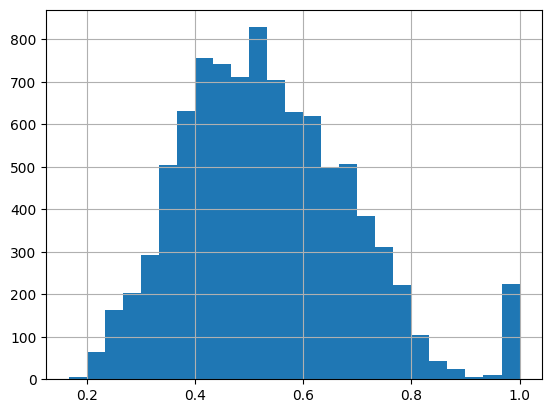

In [83]:
df_all[df_all.Set == "Shortlist"].closest_training_molecule_similarity.hist(bins=25)

In [85]:
df_all = df_all.loc[:,~df_all.columns.str.startswith("Descriptor_")]
df_all.to_csv(f'{DATA_GENERATED_FOLDER}/{TARGET_ID}_all.tsv', sep="\t", header=True, index=False)

Export data for route prediction:

In [86]:
df_all.loc[
    df_all.Set == 'Shortlist', 
    ~df_all.columns.isin(["Set", "DESIRE", "VALID", "TSNE_1", "TSNE_2"])
].to_csv(f'{DATA_GENERATED_FOLDER}/{TARGET_ID}_shortlist.csv', sep=",", index=False, header=True)

In [87]:
df_smiles_rl_sample_scores.to_csv(f'{DATA_GENERATED_FOLDER}/{TARGET_ID}.csv', sep=",", index=False, header=True)

### Score Distributions in Shortlist

array([[<AxesSubplot: title={'center': 'LED3Scorer'}>,
        <AxesSubplot: title={'center': 'XGBClassifier'}>],
       [<AxesSubplot: title={'center': 'XGBRegressor'}>,
        <AxesSubplot: title={'center': 'SA'}>]], dtype=object)

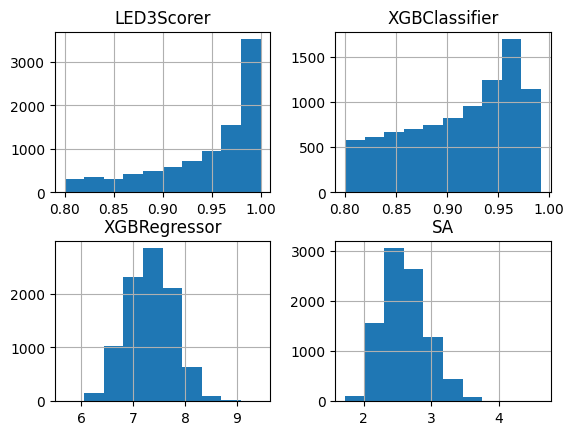

In [88]:
df_all[df_all.Set == "Shortlist"][predictor_keys].hist()

array([[<AxesSubplot: title={'center': 'LED3Scorer'}>,
        <AxesSubplot: title={'center': 'XGBClassifier'}>],
       [<AxesSubplot: title={'center': 'XGBRegressor'}>,
        <AxesSubplot: title={'center': 'SA'}>]], dtype=object)

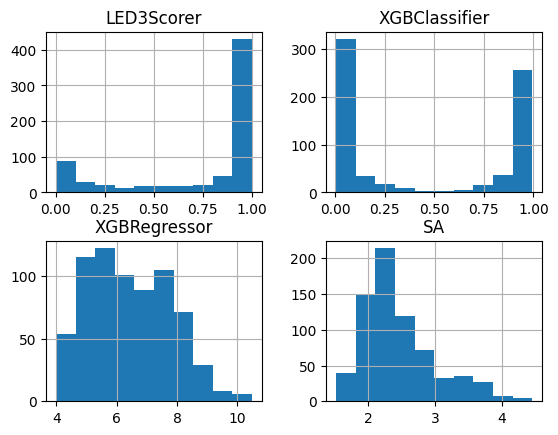

In [89]:
df_smiles_original_scores[predictor_keys].hist()

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

def create_scatter_matrix(df):
    axes = scatter_matrix(df, alpha=0.5, diagonal='kde')
    corr = df.corr().to_numpy()
    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
    plt.show()

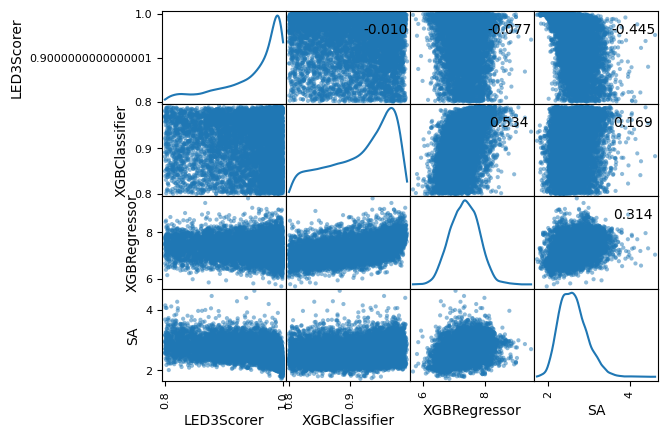

In [91]:
create_scatter_matrix(df_all[df_all.Set == "Shortlist"][predictor_keys])

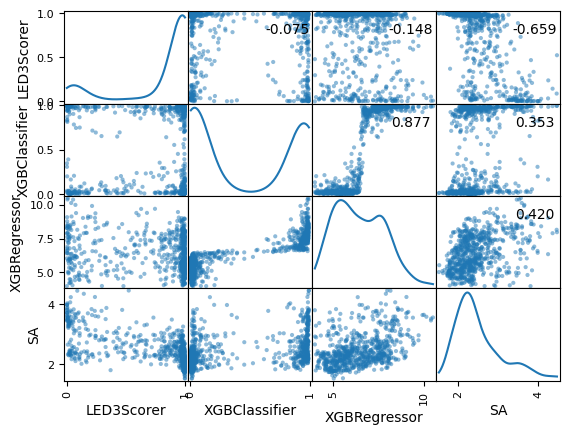

In [92]:
create_scatter_matrix(df_smiles_original_scores[predictor_keys])

### Show Chemical Spaces

Takes the big data frame with all sets and depicts subsets.

In [93]:
# prepare depiction data

df_depict_path = f'{DATA_FOLDER}/depiction/rl_shortlist_originals.tsv'
df_depict = df_all[df_all.Set.isin(["Original", "Shortlist"])]
df_depict.to_csv(df_depict_path, sep='\t', index=False, header=True)
df_depict

,SMILES,Set,TSNE_1,TSNE_2,LED3Scorer,XGBClassifier,XGBRegressor,SA,closest_training_molecule_similarity,closest_training_molecule
10532,O=C(Cc1ccc(Cc2ccccc2)cc1)OCC1CO1,Original,-9.182210,2.922164,0.585993,0.017040,4.830327,NaN,1.000000,O=C(Cc1ccc(Cc2ccccc2)cc1)OCC1CO1
10533,CCCCCCCCCC(=NO)c1c(O)ccc(-c2ccc(OC)cc2)c1,Original,-12.887296,-5.998468,0.960194,0.005677,4.439261,NaN,1.000000,CCCCCCCCCC(=NO)c1c(O)ccc(-c2ccc(OC)cc2)c1
10534,O=C1C=CC(=O)N1c1ccccc1I,Original,-4.371062,0.139172,0.968688,0.006967,5.324044,NaN,1.000000,O=C1C=CC(=O)N1c1ccccc1I
10535,O=C1C=CC(=O)N1c1ccccc1-c1ccccc1,Original,-4.951765,0.701421,0.990152,0.007051,5.770197,NaN,1.000000,O=C1C=CC(=O)N1c1ccccc1-c1ccccc1
10536,O=C1CCC(COC(=O)N2CCC(COc3c(Cl)cc(F)cc3)CC2)N1,Original,4.618637,-13.420197,0.986233,0.907512,6.735845,NaN,1.000000,O=C1CCC(COC(=O)N2CCC(COc3c(Cl)cc(F)cc3)CC2)N1
...,...,...,...,...,...,...,...,...,...,...
99871,O=Cc1ccc(N2CCC(C(=O)c3ccc(Sc4ccc(F)cc4)cc3)CC2...,Shortlist,NaN,NaN,0.997041,0.822556,6.844550,2.370118,0.488372,O=C(c1ccc(Sc2ccc(F)cc2)cc1)C1CCN(C(=O)c2cc(O)c...
99897,O=C(N1CCN(c2ccc(Br)c([N+](=O)[O-])c2)CC1)n1nnc...,Shortlist,NaN,NaN,0.995911,0.968961,7.479565,2.445486,0.655172,CN(C)C(=O)c1c([N+](=O)[O-])ccc(N2CCN(C(=O)n3nn...
99951,O=C(c1ccc(Sc2ccc(SC(F)(F)F)cc2)cc1)C1CCN(C(=O)...,Shortlist,NaN,NaN,0.966054,0.967692,8.113548,2.594992,0.763158,O=C(c1ccc(Sc2ccccc2)cc1)C1CCN(C(=O)c2cc(O)ccc2...
99970,O=C(N1CCN(Cc2ccc(Cl)c(F)c2)CC1)n1nnc2cccnc21,Shortlist,NaN,NaN,0.974232,0.958466,7.585723,2.476570,0.597826,O=C(N1CCN(Cc2cc(Oc3ccccc3)ccc2)CC1)n1nnc2c1nccc2


In [94]:
from scaffviz.clustering.descriptors import MorganFP
from scaffviz.clustering.manifold import TSNE
from scaffviz.data.dataset import DataSetTSV

dataset = DataSetTSV(df_depict_path, mol_col='SMILES')
dataset.addDescriptors([MorganFP(radius=3, nBits=2048)], recalculate=True)

100%|██████████| 9890/9890 [00:03<00:00, 3049.98it/s]


In [95]:
dataset.asDataFrame()

,SMILES,Set,TSNE_1,TSNE_2,LED3Scorer,XGBClassifier,XGBRegressor,SA,closest_training_molecule_similarity,closest_training_molecule,...,Descriptor_MorganFP_2038,Descriptor_MorganFP_2039,Descriptor_MorganFP_2040,Descriptor_MorganFP_2041,Descriptor_MorganFP_2042,Descriptor_MorganFP_2043,Descriptor_MorganFP_2044,Descriptor_MorganFP_2045,Descriptor_MorganFP_2046,Descriptor_MorganFP_2047
0,O=C(Cc1ccc(Cc2ccccc2)cc1)OCC1CO1,Original,-9.182210,2.922164,0.585993,0.017040,4.830327,NaN,1.000000,O=C(Cc1ccc(Cc2ccccc2)cc1)OCC1CO1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CCCCCCCCCC(=NO)c1c(O)ccc(-c2ccc(OC)cc2)c1,Original,-12.887296,-5.998468,0.960194,0.005677,4.439261,NaN,1.000000,CCCCCCCCCC(=NO)c1c(O)ccc(-c2ccc(OC)cc2)c1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O=C1C=CC(=O)N1c1ccccc1I,Original,-4.371062,0.139172,0.968688,0.006967,5.324044,NaN,1.000000,O=C1C=CC(=O)N1c1ccccc1I,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,O=C1C=CC(=O)N1c1ccccc1-c1ccccc1,Original,-4.951765,0.701421,0.990152,0.007051,5.770197,NaN,1.000000,O=C1C=CC(=O)N1c1ccccc1-c1ccccc1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O=C1CCC(COC(=O)N2CCC(COc3c(Cl)cc(F)cc3)CC2)N1,Original,4.618637,-13.420197,0.986233,0.907512,6.735845,NaN,1.000000,O=C1CCC(COC(=O)N2CCC(COc3c(Cl)cc(F)cc3)CC2)N1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9885,O=Cc1ccc(N2CCC(C(=O)c3ccc(Sc4ccc(F)cc4)cc3)CC2...,Shortlist,NaN,NaN,0.997041,0.822556,6.844550,2.370118,0.488372,O=C(c1ccc(Sc2ccc(F)cc2)cc1)C1CCN(C(=O)c2cc(O)c...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9886,O=C(N1CCN(c2ccc(Br)c([N+](=O)[O-])c2)CC1)n1nnc...,Shortlist,NaN,NaN,0.995911,0.968961,7.479565,2.445486,0.655172,CN(C)C(=O)c1c([N+](=O)[O-])ccc(N2CCN(C(=O)n3nn...,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9887,O=C(c1ccc(Sc2ccc(SC(F)(F)F)cc2)cc1)C1CCN(C(=O)...,Shortlist,NaN,NaN,0.966054,0.967692,8.113548,2.594992,0.763158,O=C(c1ccc(Sc2ccccc2)cc1)C1CCN(C(=O)c2cc(O)ccc2...,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9888,O=C(N1CCN(Cc2ccc(Cl)c(F)c2)CC1)n1nnc2cccnc21,Shortlist,NaN,NaN,0.974232,0.958466,7.585723,2.476570,0.597826,O=C(N1CCN(Cc2cc(Oc3ccccc3)ccc2)CC1)n1nnc2c1nccc2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from scaffviz.depiction.plot import Plot

plt = Plot(dataset)
plt.plot(
    TSNE(perplexity=500), 
    color_by="Set", 
    recalculate=True, 
    interactive=True, 
    port=9292, 
    card_data=["Set"] + predictor_keys, 
    viewport_height=1000
)

/home/martin/.conda/envs/led3-drugex/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/martin/.conda/envs/led3-drugex/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/home/martin/.conda/envs/led3-drugex/lib/python3.10/site-packages/molplotly/main.py:32: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.

/home/martin/.conda/envs/led3-drugex/lib/python3.10/site-packages/molplotly/main.py:76: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.


In [ ]:
plt.plot(
    TSNE(perplexity=500), 
    color_by="Set",
    recalculate=False, 
    interactive=False
)

In [ ]:
plt.plot(
    TSNE(perplexity=500), 
    color_by="XGBRegressor",
    recalculate=False, 
    interactive=False
)

In [ ]:
plt.plot(
    TSNE(perplexity=500), 
    color_by="LED3Scorer",
    recalculate=False, 
    interactive=False
)

In [ ]:
plt.plot(
    TSNE(perplexity=500), 
    color_by="SA",
    recalculate=False, 
    interactive=False
)